# 1.  Data Collection

In [9]:
import twitter # A library to extract text from tweets
import secret_keys # My personal library where the secret Twitter API keys are located

#Instructions on how to setup the API: https://python-twitter.readthedocs.io/en/latest/getting_started.html
api = twitter.Api(consumer_key=secret_keys.consumer_key,
                  consumer_secret=secret_keys.consumer_secret,
                  access_token_key=secret_keys.access_token,
                  access_token_secret=secret_keys.access_token_secret)

# Now search the twitter with a query term
query_term = 'machine learning' # data science, IPL, etc
no_of_tweets = 1000
results = api.GetSearch(term = query_term, count = no_of_tweets, since = '2020-10-01')

# 2. Data Storage

In [10]:
# Creating a list of tweets (Data stored in a format suitable for easy processing)
df = []
for t in results:
    df.append(t.text) 

In [23]:
import pandas as pd

df2 = pd.DataFrame(df)

# Save the dataframe as csv
df2.to_csv('tweets.csv', index = False, header = ['tweet'])

In [21]:
df2

,0
0,My latest for @hyperallergic was co-written w/...
1,Notice a new feature on @arxiv? Machine learni...
2,Inspired by yesterday's #ArmDevSummit tinyML w...
3,"RT @dougbrownDBA: A simple guide to AI, Machin..."
4,RT @dougbrownDBA: AI and Machine Learning: Top...
...,...
95,"RT @laanlabs: We added a new ""object masking"" ..."
96,"RT @techreview: Frankly, the process of machin..."
97,"RT @techreview: Frankly, the process of machin..."
98,RT @SarahEBond: My latest for @hyperallergic w...


# 3. Data Cleaning

In [11]:
# Basic NLP data cleaning 
import string

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

# initialise WordNet lemmatizer and punctuation filter
lemmatizer = WordNetLemmatizer()
punct = set(string.punctuation)


# default NLTK English stopwords
stopwords =set(sw.words('english'))

def lemmatize(token, tag):
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)

    return lemmatizer.lemmatize(token, tag)

def social_tokenizer(document):
    # initialize token list
    tokens = []
    
    # split the document into sentences
    for sent in sent_tokenize(document):
        # split the document into tokens and then create part of speech tag for each token
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            # preprocess and remove unnecessary characters
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')

            # If stopword, ignore token and continue
            if token in stopwords:
                continue

            # If punctuation, ignore token and continue
            if all(char in punct for char in token):
                continue

            # Lemmatize the token and add back to the tokens list
            lemma = lemmatize(token, tag)
            tokens.append(lemma)
    
    return tokens

# 4. Data Representation
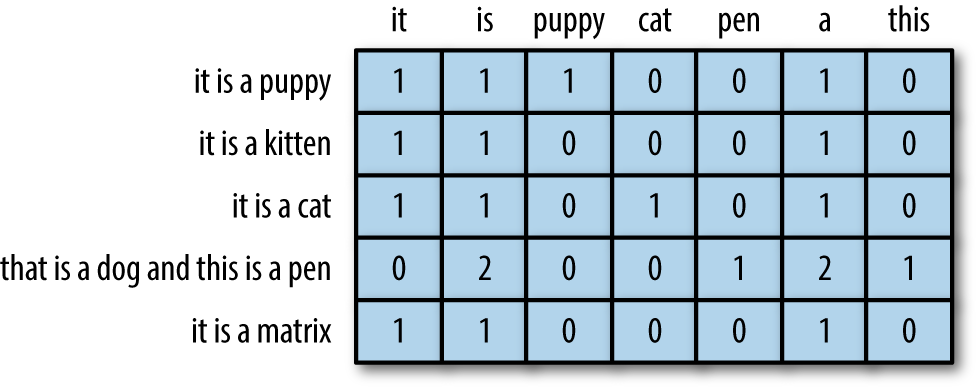
Image source: https://www.oreilly.com/library/view/feature-engineering-for/9781491953235/ch04.html

In [12]:
# tf idf vectoriser
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(tokenizer=social_tokenizer, ngram_range=(1,2))

X = tfidf_vec.fit_transform(df)
feature_names = tfidf_vec.get_feature_names()

# 5. Topic Modelling using NMF

In [13]:
from sklearn.decomposition import NMF
rank = 5
model = NMF(n_components=rank, init='random', random_state=0)
W = model.fit_transform(X) # Document clustering
H = model.components_ # Topic modelling

In [14]:
H

array([[0.01548889, 0.00249761, 0.02767996, ..., 0.00373293, 0.00891439,
        0.00891439],
       [0.        , 0.00058657, 0.        , ..., 0.00265362, 0.00322509,
        0.00322509],
       [0.        , 0.        , 0.        , ..., 0.00310865, 0.00160461,
        0.00160461],
       [0.        , 0.        , 0.00033303, ..., 0.00047952, 0.00247781,
        0.00247781],
       [0.        , 0.00019465, 0.        , ..., 0.00168569, 0.00241519,
        0.00241519]])

# 6. Visualization

In [15]:
# Visualization of top 10 words in each topic. This is generated based on the values in H
for i,topic in enumerate(H):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vec.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['rt', 'datascience', 'machine', 'machine learning', 'azure', 'learning', 'ai', 'co', 'http', 'http co']


Top 10 words for topic #1:
['link official', 'article code', 'arxiv', 'arxiv machine', 'new feature', 'notice', 'notice new', 'article', 'feature arxiv', 'code']


Top 10 words for topic #2:
['co', 'learn technology', 'learn', 'fintech', 'learn https', 'top', 'machinelearning', 'https co', 'https', 'rail']


Top 10 words for topic #3:
['http co', 'get', 'head', 'scientist', 'scientist http', 'inside head', 'get inside', 'learn scientist', 'inside', 'head machine']


Top 10 words for topic #4:
['online', 'ai ’', 'online shopping', 'ecommerce', 'ai io', 'role future', 'zjlvbe5ehl ai', 'role', 'shopping bigcommerce', 'ai']




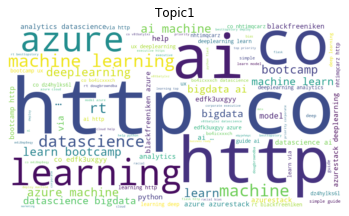

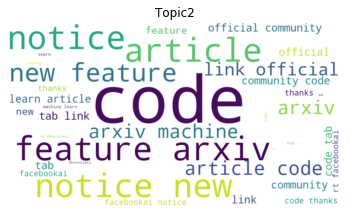

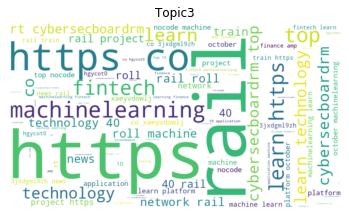

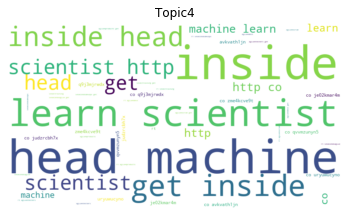

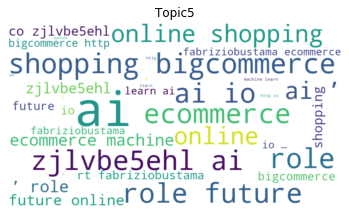

In [16]:
# Visualization of topics as word-cloud
topic_words = []
topic_values = []
n_top_words = 100
for i in range(0,rank):
    topic_words.append([feature_names[i] for i in model.components_[i].argsort()[:-n_top_words - 1 :-1]])
    topic_values.append([model.components_[i][j] for j in model.components_[i].argsort()[:-n_top_words - 1 :-1]])

import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
for i in range(0,5):
    titl = 'Topic'+str(i+1)
    d = {}
    for q in range(0,len(topic_words[i])):
        a = topic_words[i][q]
        #print(a)
        d[topic_words[i][q]] = topic_values[i][q]
    wordcloudi = WordCloud(background_color='white',width=900,height=500, max_words=100,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(frequencies = d)
    plt.imshow(wordcloudi, interpolation='bilinear')
    plt.axis("off")
    plt.title(titl)
    plt.show()
    #plt.imshow(firstcloud)
    #plt.axis('off')
    #plt.show()